<a href="https://colab.research.google.com/github/acf62/dcgan-colab/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

**DCGAN.py**

In [0]:
import torch.nn as nn


# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
nfg = 64

# Size of feature maps in discriminator
nfd = 64


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.optimizer = None
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, nfg * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nfg * 4),
            nn.ReLU(True),

            # nn.ConvTranspose2d(nfg * 8, nfg * 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nfg * 4),
            # nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 4, nfg * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 2, nfg * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfg * 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(nfg * 1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.optimizer = None
        self.main = nn.Sequential(
            nn.Conv2d(nc, nfd, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd, nfd * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd * 2, nfd * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # nn.Conv2d(nfd * 4, nfd * 8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nfd * 8),
            # nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd * 4, 1, 4, 1, 0, bias=False),
            
            nn.Linear(1, 1)
        )

    def forward(self, x):
        return self.main(x)


Training.py

Initialize

In [0]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# Number of generators
num_generators = 1

# Number of training epochs
num_epochs = 10

# Steps for each generator to take before moving to the next one
gen_steps = 1

# Learning rate for optimizers
lr = 0.00005

# Beta1 hyperparameter for Adam optimizers
# beta1 = 0.5

# Initialize BCELoss function
# criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

def initialize_weights(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(layer.weight.data, 1.0, 0.02)
        nn.init.constant_(layer.bias.data, 0)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Create latent vectors to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


# Create Generator list and Discriminator
G = [Generator(ngpu=ngpu).to(device) for _ in range(num_generators)]
D = Discriminator(ngpu=ngpu).to(device)

# Initialize the network weights
[Gi.apply(initialize_weights) for Gi in G]
D.apply(initialize_weights)

# Setup RMSProp optimizers for both G and D
D.optimizer = optim.RMSprop(D.parameters(), lr=lr)
for Gi in G: 
    Gi.optimizer = optim.RMSprop(Gi.parameters(), lr=lr)

Train

In [0]:
def data_log(iters, epoch, data_length, err_D, err_Gi, D_x, D_Gi_z1, D_Gi_z2, i):
    # Print training statistics and save losses for plotting
    print('[%d][%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (i, epoch+1, num_epochs, iters, data_length,
          err_D.item(), err_Gi.item(), D_x, D_Gi_z1, D_Gi_z2))
            
    D_losses[i].append(err_D.item())
    G_losses[i].append(err_Gi.item())

# Log an image for each generator          
def image_log():
    for i in range(num_generators):
        with torch.no_grad():
            fake = G[i](fixed_noise).detach().cpu()
        img_list[i].append(vutils.make_grid(fake, padding=2, normalize=True))


def step(Gi, data):
    fake = None
    for _ in range(5):
        # Discriminator real samples
        D.zero_grad()
        batch = data[0].to(device)
        output = D(batch).view(-1)
        batch_size = batch.size(0)
        # labels = torch.full((batch_size, ), real_label, device=device)
        err_D_real = -torch.mean(output)
        err_D_real.backward()
        D_x = output.mean().item()

        # Discriminator fake samples
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = Gi(noise)
        output = D(fake.detach()).view(-1)
        # labels.fill_(fake_label)
        err_D_fake = torch.mean(output)
        err_D_fake.backward()
        err_D = err_D_real + err_D_fake
        D_Gi_z1 = output.mean().item()

        # Discriminator step
        D.optimizer.step()

        # Clamp weights for Wasserstein GAN
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

    # Generator trained with improved Discriminator
    Gi.zero_grad()
    # labels.fill_(real_label)
    output = D(fake).view(-1)
    err_Gi = -torch.mean(output)
    err_Gi.backward()
    D_Gi_z2 = output.mean().item()
   
    # Generator step
    Gi.optimizer.step()

    return err_D, err_Gi, D_x, D_Gi_z1, D_Gi_z2


def train(data_loader):
    for epoch in range(num_epochs):
        iters = 0
        i = epoch % num_generators
        for data in data_loader:
            # Optimization Step
            Gi = G[i]
            err_D, err_Gi, D_x, D_Gi_z1, D_Gi_z2 = step(Gi, data)
            
            if (iters + 1) % gen_steps == 0:
                # Log for plotting
                data_log(iters, epoch, len(data_loader), err_D, err_Gi, D_x, D_Gi_z1, D_Gi_z2, i)
                # Train next generator  
                i = (i + 1) % num_generators
            iters += 1
        image_log()           

**Evaluation.py**

In [0]:
import torch.utils.data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

# Root directory for dataset
dataroot = "data"

# Number of workers for data_loader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32


# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dsets.CIFAR10(root=dataroot, train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5,))
                           ]))


# Create the data_loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Lists to hold the data for plotting
img_list = [[] for _ in range(num_generators)]
G_losses = [[] for _ in range(num_generators)]
D_losses = [[] for _ in range(num_generators)]
display = 0

# Train the GAN
train(data_loader)


Files already downloaded and verified
[0][1/10][0/391]	Loss_D: -0.0001	Loss_G: 0.0100	D(x): -0.0100	D(G(z)): -0.0100 / -0.0100
[0][1/10][1/391]	Loss_D: -0.0000	Loss_G: 0.0100	D(x): -0.0100	D(G(z)): -0.0100 / -0.0100
[0][1/10][2/391]	Loss_D: 0.0000	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][3/391]	Loss_D: 0.0000	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][4/391]	Loss_D: 0.0001	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][5/391]	Loss_D: 0.0001	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][6/391]	Loss_D: 0.0001	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][7/391]	Loss_D: 0.0001	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][8/391]	Loss_D: 0.0001	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][9/391]	Loss_D: 0.0001	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 / -0.0099
[0][1/10][10/391]	Loss_D: 0.0001	Loss_G: 0.0099	D(x): -0.0100	D(G(z)): -0.0099 /

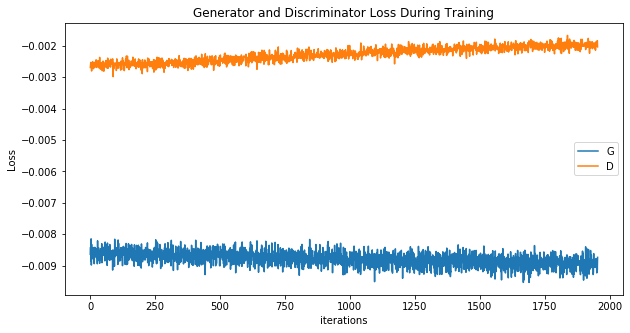

In [37]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[display],label="G")
plt.plot(D_losses[display],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

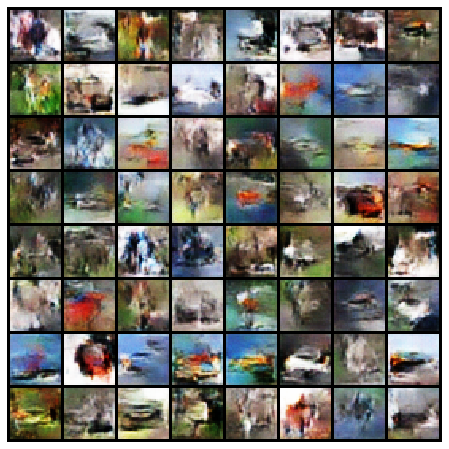

In [38]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i ,(1,2,0)), animated=True)] for i in img_list[display]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

display += 1
HTML(ani.to_jshtml())

In [0]:
print(display)

5
